In [57]:
import re
import ssl
import numpy as np
import pandas as pd
import pycountry
import pycountry_convert as pc
from toolkit import *
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt

In [36]:
df=toolkit.load_data() 
df = df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)
df=df.iloc[:400000,:]

In [37]:
df.head(5) 

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history,geometry,country_transaction,continent_transaction,continent_user,continent_merchant
0,TX290822,2022-01-08 10:03:00,U00001,M0906,19.09,online,EUR,Web,debit_card,1,...,0.631421,2,26.85,37,0,POINT (-7.72625 69.291741),Ocean,Ocean,Europe,Europe
1,TX197951,2022-01-08 16:48:00,U00001,M0245,32.24,online,EUR,Android,mobile_payment,1,...,0.859810,2,197.43,115,1,POINT (15.368695 54.710715),Ocean,Ocean,Europe,Europe
2,TX187979,2022-01-12 16:23:00,U00001,M0332,4.29,in-store,EUR,Android,debit_card,1,...,0.934815,5,18.36,68,0,POINT (30.25543 58.897717),Russia,Asia,Europe,Europe
3,TX137034,2022-01-18 10:40:00,U00001,M0331,67.00,in-store,EUR,iOS,debit_card,1,...,0.859404,6,123.91,94,1,POINT (3.843828 42.684202),Ocean,Ocean,Europe,Europe
4,TX401318,2022-07-18 08:05:00,U00001,M0971,3.59,in-store,EUR,Web,mobile_payment,1,...,0.516453,1,0.98,52,1,POINT (15.749937 44.296089),Croatia,Europe,Europe,Europe


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   transaction_id                  400000 non-null  object 
 1   timestamp                       400000 non-null  object 
 2   user_id                         400000 non-null  object 
 3   merchant_id                     400000 non-null  object 
 4   amount                          400000 non-null  float64
 5   channel                         400000 non-null  object 
 6   currency                        400000 non-null  object 
 7   device                          400000 non-null  object 
 8   payment_method                  400000 non-null  object 
 9   is_international                400000 non-null  int64  
 10  session_length_seconds          400000 non-null  int64  
 11  is_first_time_merchant          400000 non-null  int64  
 12  is_fraud        

### Null values 

In [39]:
df.isnull().sum()

transaction_id                    0
timestamp                         0
user_id                           0
merchant_id                       0
amount                            0
channel                           0
currency                          0
device                            0
payment_method                    0
is_international                  0
session_length_seconds            0
is_first_time_merchant            0
is_fraud                          0
age                               0
sex                               0
education                         0
primary_source_of_income          0
sum_of_monthly_installments       0
sum_of_monthly_expenses           0
country_user                      0
signup_date                       0
risk_score                        0
category                          0
country_merchant                  0
trust_score                       0
number_of_alerts_last_6_months    0
avg_transaction_amount            0
account_age_months          

### Overall information

In [40]:
df.describe()

,amount,is_international,session_length_seconds,is_first_time_merchant,is_fraud,age,sum_of_monthly_installments,sum_of_monthly_expenses,risk_score,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,49.893076,0.928907,615.152028,0.501108,0.084735,45.897705,301.012888,1179.585598,0.500979,0.683019,3.057412,81.935498,61.548950,0.520790
std,49.991394,0.256980,338.359012,0.499999,0.278487,16.533566,302.688739,1167.804174,0.150785,0.194401,1.722183,79.247800,33.440963,0.499568
min,0.000000,0.000000,30.000000,0.000000,0.000000,18.000000,0.010000,0.040000,0.000000,0.000000,0.000000,0.120000,6.000000,0.000000
25%,14.330000,1.000000,323.000000,0.000000,0.000000,32.000000,87.330000,353.640000,0.396987,0.546098,2.000000,24.790000,32.000000,0.000000
50%,34.510000,1.000000,615.000000,1.000000,0.000000,46.000000,207.565000,825.190000,0.499828,0.697761,3.000000,58.290000,61.000000,1.000000
75%,69.120000,1.000000,908.000000,1.000000,0.000000,60.000000,416.430000,1644.010000,0.604101,0.826846,4.000000,117.200000,92.000000,1.000000
max,607.110000,1.000000,1200.000000,1.000000,1.000000,74.000000,3165.700000,10994.330000,1.000000,1.000000,9.000000,709.040000,119.000000,1.000000


array([[<Axes: title={'center': 'amount'}>,
        <Axes: title={'center': 'is_international'}>,
        <Axes: title={'center': 'session_length_seconds'}>,
        <Axes: title={'center': 'is_first_time_merchant'}>],
       [<Axes: title={'center': 'is_fraud'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'sum_of_monthly_installments'}>,
        <Axes: title={'center': 'sum_of_monthly_expenses'}>],
       [<Axes: title={'center': 'risk_score'}>,
        <Axes: title={'center': 'trust_score'}>,
        <Axes: title={'center': 'number_of_alerts_last_6_months'}>,
        <Axes: title={'center': 'avg_transaction_amount'}>],
       [<Axes: title={'center': 'account_age_months'}>,
        <Axes: title={'center': 'has_fraud_history'}>, <Axes: >,
        <Axes: >]], dtype=object)

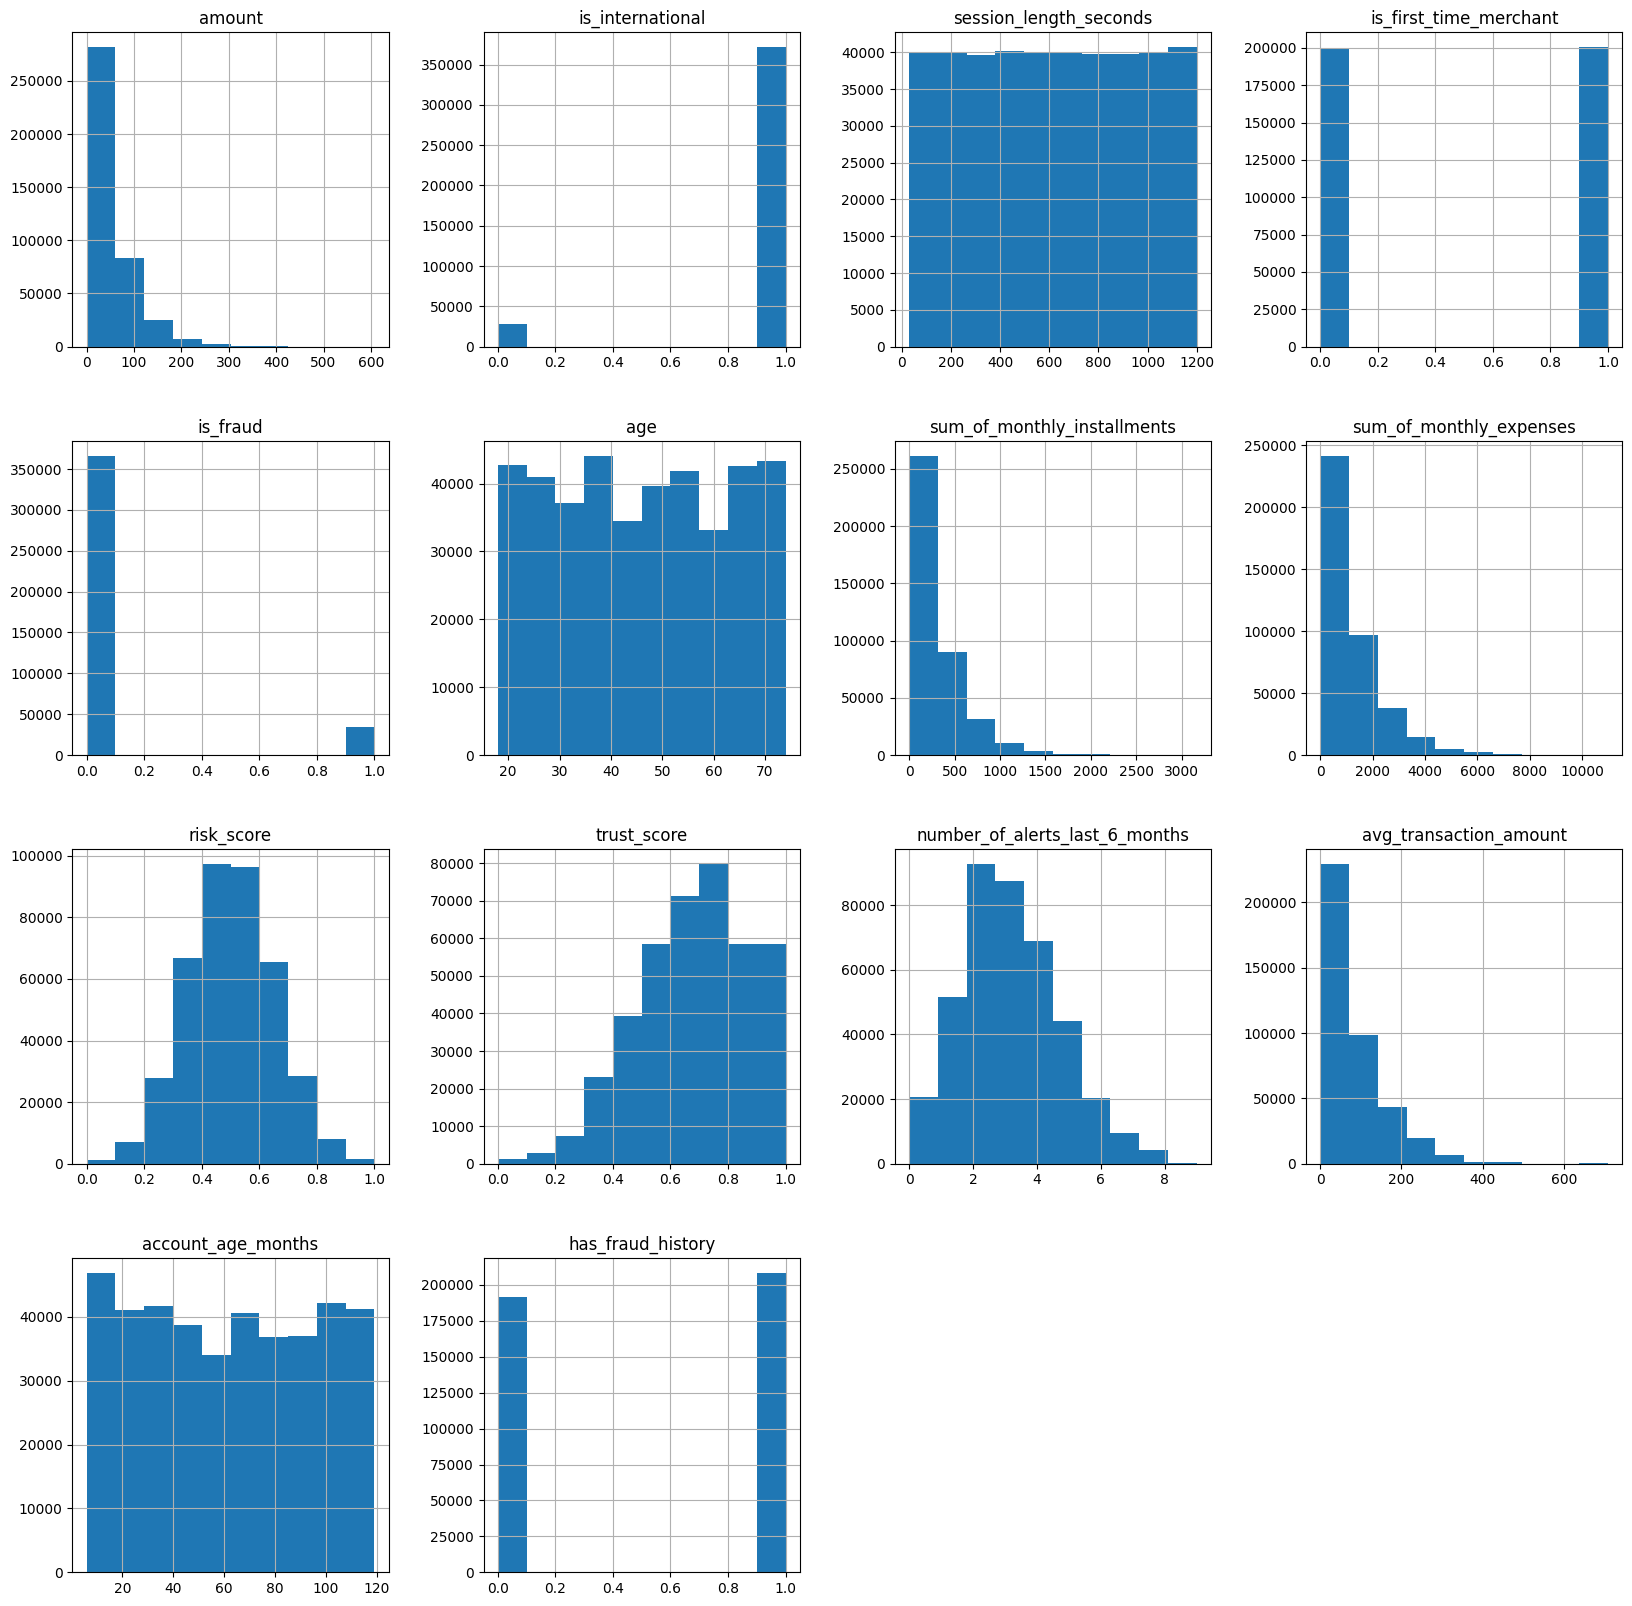

In [41]:
df.hist(figsize=(20,20))

### Analyzing location 

In [ ]:
ssl._create_default_https_context = ssl._create_unverified_context
countries_url = (
    "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
)
world = gpd.read_file(countries_url)

In [ ]:
df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
world = world[['name', 'ISO3166-1-Alpha-3', 'geometry']]
world = world.rename(columns={
    'name': 'ADMIN',
    'ISO3166-1-Alpha-3': 'ISO_A3'
})
gdf = gpd.GeoDataFrame(
    df,
    geometry='geometry',       
    crs="EPSG:4326"        
)

pts = gpd.sjoin(
    gdf,
    world,
    how='left',
    predicate='within'
)


In [ ]:
pts_webm = pts.iloc[1:1000, :].to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(10, 8))
pts_webm.plot(
    ax=ax,
    markersize=40,
    cmap='plasma',
    legend=True,
    alpha=0.8,
    edgecolor='k'
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title("Point Locations")
ax.set_axis_off()
plt.tight_layout()
plt.show()


### Basic features

<Axes: xlabel='device', ylabel='Count'>

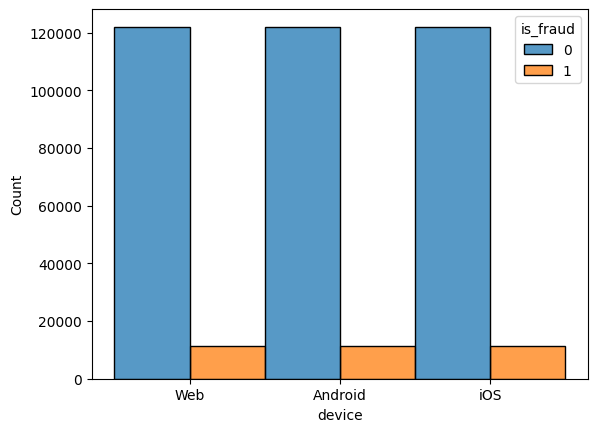

In [8]:
sns.histplot(data=df,x='device',hue='is_fraud',multiple='dodge') 

<Axes: xlabel='channel', ylabel='Count'>

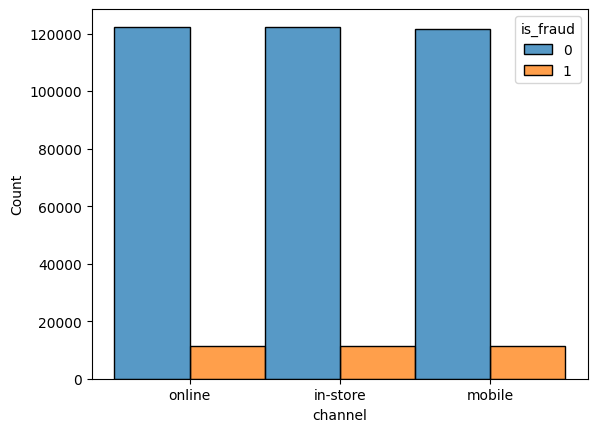

In [10]:
sns.histplot(data=df,x='channel',hue='is_fraud',multiple='dodge') 

<Axes: xlabel='risk_score', ylabel='Density'>

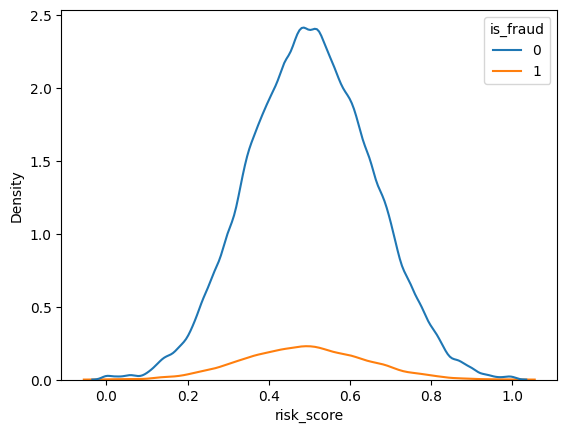

In [13]:
sns.kdeplot(data=df,x='risk_score',hue='is_fraud') 

<Axes: xlabel='category', ylabel='Count'>

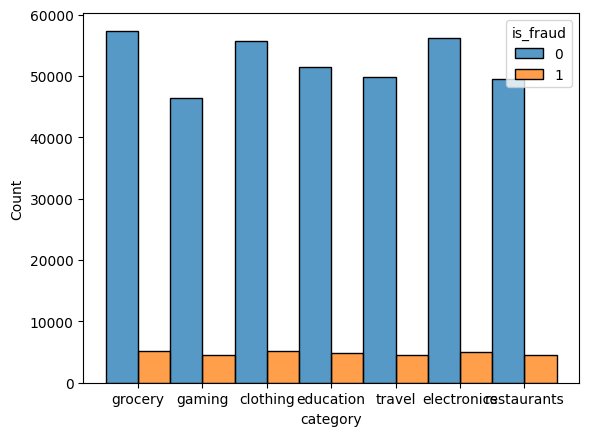

In [15]:
sns.histplot(data=df,x='category',hue='is_fraud',multiple='dodge') 

<Axes: xlabel='education', ylabel='Count'>

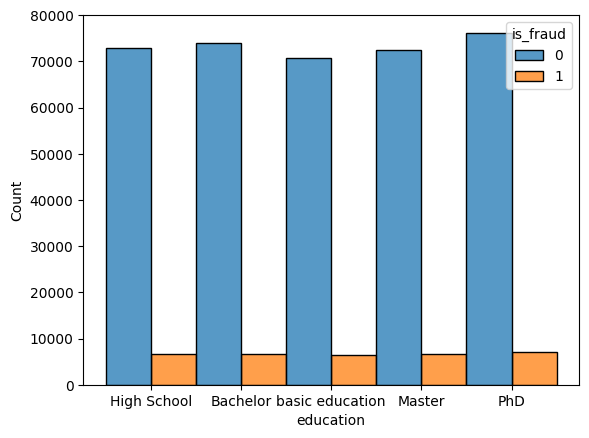

In [16]:
sns.histplot(data=df,x='education',hue='is_fraud',multiple='dodge')  

<Axes: xlabel='account_age_months', ylabel='Density'>

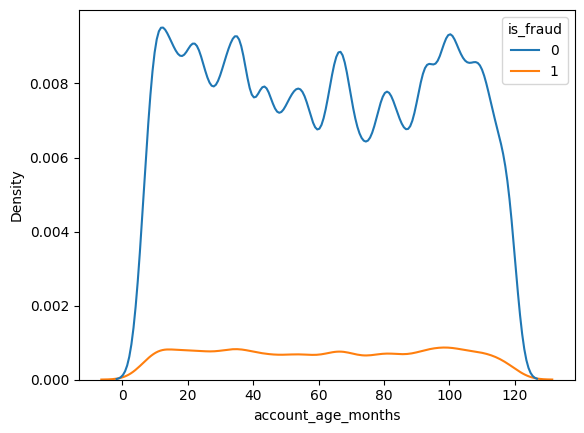

In [18]:
sns.kdeplot(data=df,x='account_age_months',hue='is_fraud')  

<Axes: xlabel='number_of_alerts_last_6_months', ylabel='Density'>

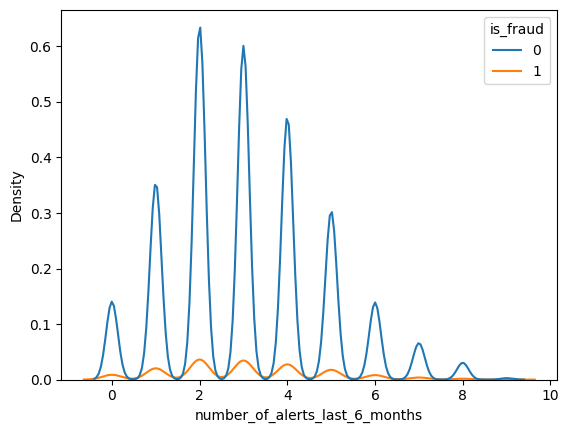

In [19]:
sns.kdeplot(data=df,x='number_of_alerts_last_6_months',hue='is_fraud')  

<Axes: xlabel='primary_source_of_income', ylabel='Count'>

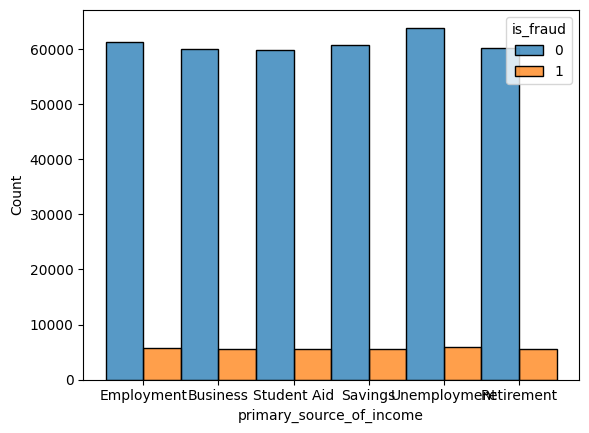

In [20]:
sns.histplot(data=df,x='primary_source_of_income',hue='is_fraud',multiple='dodge')  

### Time aspect 

In [47]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date
df['month'] = pd.to_datetime(df['timestamp']).dt.month
df['day'] = pd.to_datetime(df['timestamp']).dt.day
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['minute'] = pd.to_datetime(df['timestamp']).dt.minute
df['weekday'] = pd.to_datetime(df['timestamp']).dt.weekday 

<Axes: xlabel='month', ylabel='Count'>

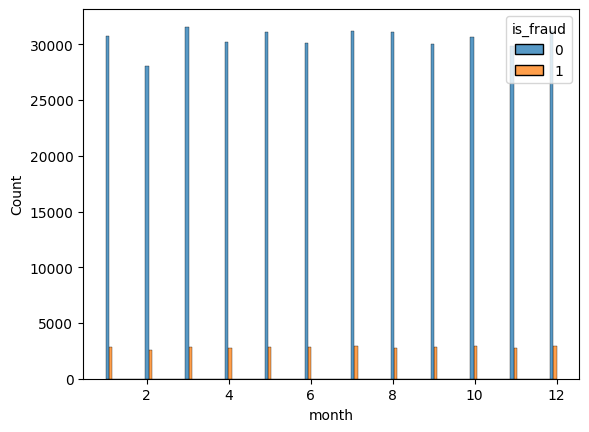

In [49]:
sns.histplot(data=df,x='month',hue='is_fraud',multiple='dodge') 

<Axes: xlabel='day', ylabel='Count'>

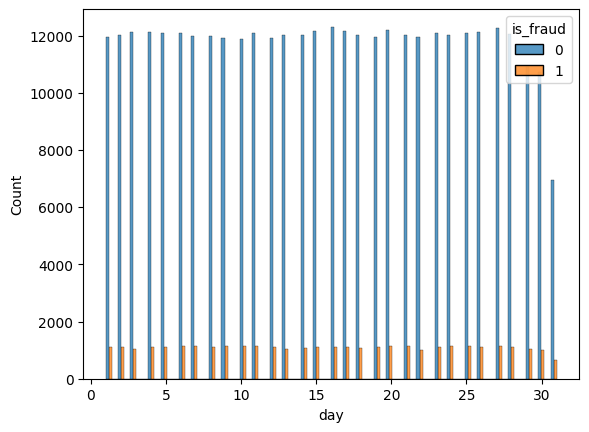

In [50]:
sns.histplot(data=df,x='day',hue='is_fraud',multiple='dodge') 

<Axes: xlabel='hour', ylabel='Count'>

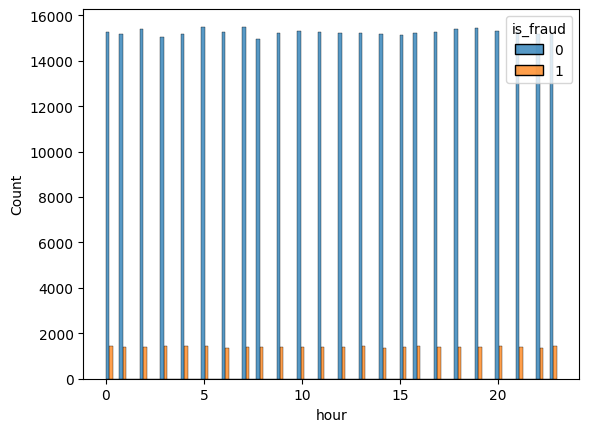

In [51]:
sns.histplot(data=df,x='hour',hue='is_fraud',multiple='dodge') 

### Let's correlation matrix

In [54]:
NUMERICAL = ['amount', 'session_length_seconds', 'age', 'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'risk_score', 'number_of_alerts_last_6_months', 'avg_transaction_amount', 'account_age_months', 'trust_score']
CATEGORICAL = ['channel', 'currency', 'device', 'payment_method', 'is_international', 'is_first_time_merchant', 'sex', 'education', 'primary_source_of_income', 'category', 'country_user',
                'country_merchant', 'continent_merchant', 'continent_user', 'has_fraud_history', 'country_transaction', 'continent_transaction']
len(NUMERICAL) + len(CATEGORICAL)

27

<Axes: >

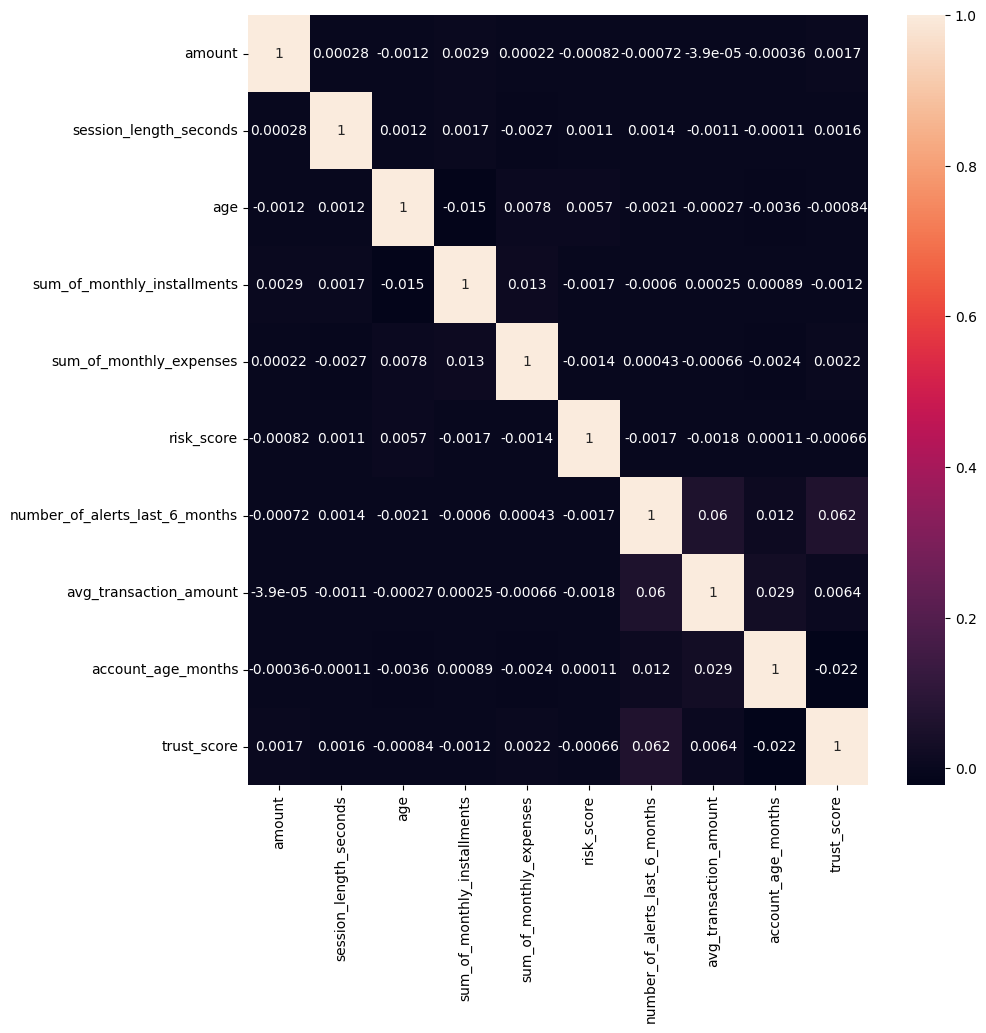

In [55]:
plt.figure(figsize=(10,10))
sns.heatmap(df.loc[:,NUMERICAL].corr(), annot=True)

### Numerical features

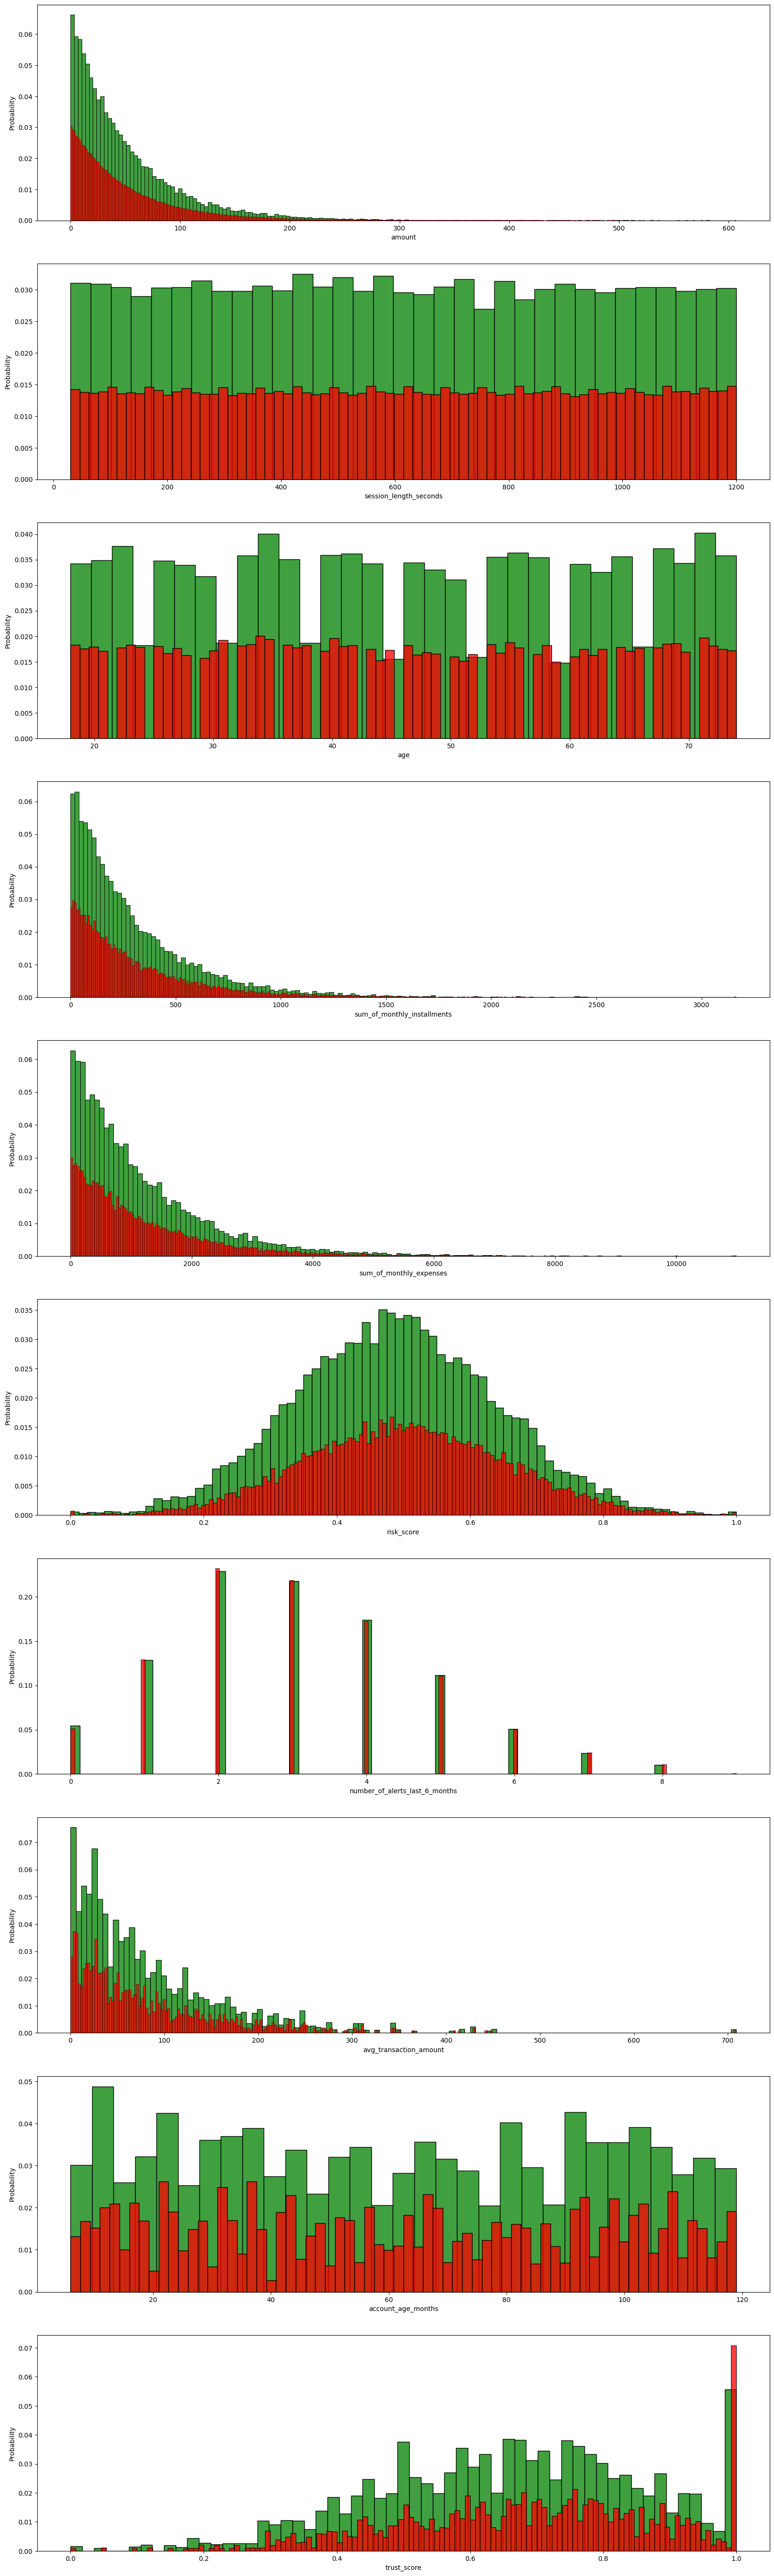

In [56]:
plt.figure(figsize=(20, len(NUMERICAL) * 7))

for index in range(len(NUMERICAL)):
    plt.subplot(len(NUMERICAL), 1, index + 1)

    column = NUMERICAL[index]
    sns.histplot(df.loc[df["is_fraud"] == 1, column], color="green", stat="probability")
    sns.histplot(df.loc[df["is_fraud"] == 0, column], color="red", stat="probability")
